# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

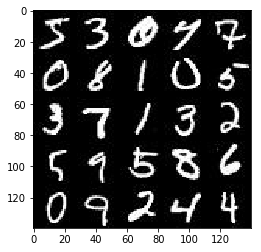

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

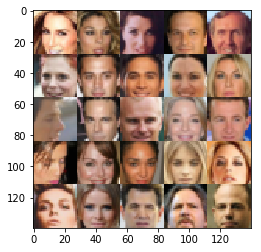

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [36]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    def swish(x):
        return x * tf.sigmoid(x)
        #return tf.maximum(x*0.25, x)
        
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = swish(x1)
        #14x14
        
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = swish(x2)
        #7x7
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = swish(x3)
        #4x4
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.glorot_uniform_initializer())
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    with tf.variable_scope('generator', reuse = not is_train):
        # TODO: Implement Function
        x1 = tf.layers.dense(z, 4*4*256,kernel_initializer=tf.glorot_uniform_initializer())
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)
        #4x4

        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)
        #7x7
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.relu(x3)
        #14x14

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #28x28
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [38]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen_m = generator(input_z, out_channel_dim)
    dis_r, dis_r_logits = discriminator(input_real, reuse=False)
    dis_f, dis_f_logits = discriminator(gen_m, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_r_logits, labels=tf.ones_like(dis_r_logits)*.95))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_f_logits, labels=tf.zeros_like(dis_f_logits)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_f_logits, labels=tf.ones_like(dis_f_logits)))
    
    d_loss = d_loss_real + d_loss_fake
    
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    
    # TODO: Build Model
    _, w, h, c = data_shape
    
    if data_image_mode == 'RGB':
        out_channel_dim = 3
    else:
        out_channel_dim = 1
    
    input_real, input_z, lr = model_inputs(w, h, c, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_op, g_op = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    sample_images = 25
    
    
    step = 1
    with tf.Session() as sess:       
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()

        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_op, feed_dict={input_real: batch_images*2, 
                                              input_z: batch_z, 
                                              lr: learning_rate})
                
                _ = sess.run(g_op, feed_dict={input_z: batch_z, 
                                              input_real: batch_images*2, 
                                              lr: learning_rate})
                

                if step%50==0:
                    dl, gl = sess.run([d_loss, g_loss], feed_dict={input_real: batch_images, 
                                              input_z: batch_z})
                    print('Step: {}-{} | Generator Loss: {:.4f} | Discriminator Loss: {:.4f}'.format(epoch_i, step, gl, dl))
                    
                if step%400==1:
                    show_generator_output(sess, sample_images, input_z, out_channel_dim, data_image_mode)
                step+=1
            saver.save(sess, './checkpoints/generator.ckpt')
        print("Final output")
        show_generator_output(sess, sample_images, input_z, out_channel_dim, data_image_mode)
                
            
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

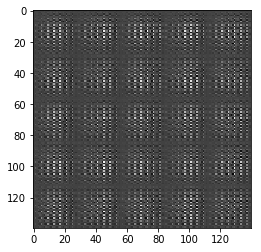

Step: 0-50 | Generator Loss: 0.5564 | Discriminator Loss: 1.6865
Step: 0-100 | Generator Loss: 1.5050 | Discriminator Loss: 1.2090
Step: 0-150 | Generator Loss: 0.3533 | Discriminator Loss: 2.1804
Step: 0-200 | Generator Loss: 0.3230 | Discriminator Loss: 1.8850
Step: 0-250 | Generator Loss: 0.9562 | Discriminator Loss: 1.3818
Step: 0-300 | Generator Loss: 0.4404 | Discriminator Loss: 1.4617
Step: 0-350 | Generator Loss: 0.6183 | Discriminator Loss: 1.6582
Step: 0-400 | Generator Loss: 0.4274 | Discriminator Loss: 1.5963


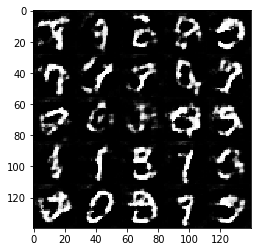

Step: 0-450 | Generator Loss: 0.6619 | Discriminator Loss: 1.3280
Step: 0-500 | Generator Loss: 0.3224 | Discriminator Loss: 1.6752
Step: 0-550 | Generator Loss: 0.8951 | Discriminator Loss: 1.2843
Step: 0-600 | Generator Loss: 0.6385 | Discriminator Loss: 1.4328
Step: 0-650 | Generator Loss: 0.6070 | Discriminator Loss: 1.4447
Step: 0-700 | Generator Loss: 1.1374 | Discriminator Loss: 1.3255
Step: 0-750 | Generator Loss: 0.3947 | Discriminator Loss: 1.6054
Step: 0-800 | Generator Loss: 0.6310 | Discriminator Loss: 1.3739


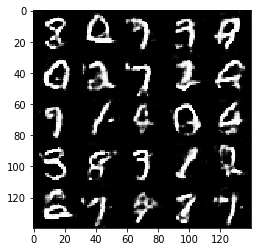

Step: 0-850 | Generator Loss: 0.2140 | Discriminator Loss: 2.0603
Step: 0-900 | Generator Loss: 0.3903 | Discriminator Loss: 1.6258
Step: 0-950 | Generator Loss: 0.6739 | Discriminator Loss: 1.3492
Step: 0-1000 | Generator Loss: 0.2569 | Discriminator Loss: 1.9168
Step: 0-1050 | Generator Loss: 0.8891 | Discriminator Loss: 0.9431
Step: 0-1100 | Generator Loss: 0.7106 | Discriminator Loss: 1.0926
Step: 0-1150 | Generator Loss: 0.6438 | Discriminator Loss: 1.3036
Step: 0-1200 | Generator Loss: 1.0980 | Discriminator Loss: 0.9426


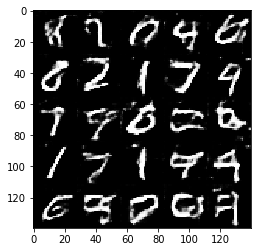

Step: 0-1250 | Generator Loss: 1.6907 | Discriminator Loss: 0.9356
Step: 0-1300 | Generator Loss: 1.4786 | Discriminator Loss: 1.2153
Step: 0-1350 | Generator Loss: 1.8069 | Discriminator Loss: 0.7003
Step: 0-1400 | Generator Loss: 0.6209 | Discriminator Loss: 1.2537
Step: 0-1450 | Generator Loss: 1.2186 | Discriminator Loss: 1.2347
Step: 0-1500 | Generator Loss: 0.5132 | Discriminator Loss: 1.4002
Step: 0-1550 | Generator Loss: 1.0730 | Discriminator Loss: 1.0208
Step: 0-1600 | Generator Loss: 0.4245 | Discriminator Loss: 1.6077


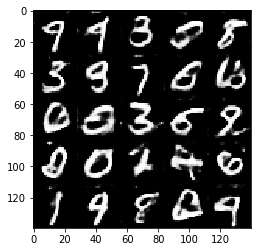

Step: 0-1650 | Generator Loss: 1.0163 | Discriminator Loss: 1.8017
Step: 0-1700 | Generator Loss: 1.6343 | Discriminator Loss: 1.7142
Step: 0-1750 | Generator Loss: 0.7781 | Discriminator Loss: 1.3434
Step: 0-1800 | Generator Loss: 1.1857 | Discriminator Loss: 1.7689
Step: 0-1850 | Generator Loss: 2.3099 | Discriminator Loss: 2.2536
Step: 1-1900 | Generator Loss: 1.1078 | Discriminator Loss: 2.0988
Step: 1-1950 | Generator Loss: 1.6973 | Discriminator Loss: 1.7248
Step: 1-2000 | Generator Loss: 1.8735 | Discriminator Loss: 2.4751


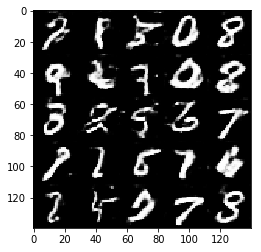

Step: 1-2050 | Generator Loss: 0.8413 | Discriminator Loss: 2.4613
Step: 1-2100 | Generator Loss: 0.6071 | Discriminator Loss: 2.4808
Step: 1-2150 | Generator Loss: 0.9615 | Discriminator Loss: 0.9315
Step: 1-2200 | Generator Loss: 2.8823 | Discriminator Loss: 0.7641
Step: 1-2250 | Generator Loss: 0.5879 | Discriminator Loss: 2.2764
Step: 1-2300 | Generator Loss: 0.7207 | Discriminator Loss: 2.4164
Step: 1-2350 | Generator Loss: 1.7653 | Discriminator Loss: 0.9667
Step: 1-2400 | Generator Loss: 0.5445 | Discriminator Loss: 1.7451


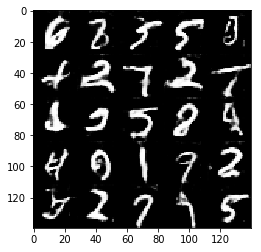

Step: 1-2450 | Generator Loss: 1.1593 | Discriminator Loss: 0.7662
Step: 1-2500 | Generator Loss: 0.4473 | Discriminator Loss: 2.0069
Step: 1-2550 | Generator Loss: 0.4961 | Discriminator Loss: 1.5831
Step: 1-2600 | Generator Loss: 0.9908 | Discriminator Loss: 1.0342
Step: 1-2650 | Generator Loss: 0.4778 | Discriminator Loss: 1.4631
Step: 1-2700 | Generator Loss: 2.9762 | Discriminator Loss: 0.5599
Step: 1-2750 | Generator Loss: 0.6075 | Discriminator Loss: 1.4105
Step: 1-2800 | Generator Loss: 0.5599 | Discriminator Loss: 1.9138


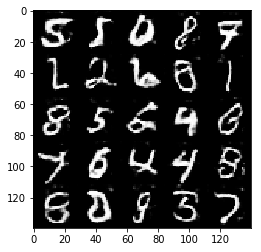

Step: 1-2850 | Generator Loss: 0.6895 | Discriminator Loss: 1.4209
Step: 1-2900 | Generator Loss: 2.9481 | Discriminator Loss: 0.3396
Step: 1-2950 | Generator Loss: 1.0978 | Discriminator Loss: 1.4169
Step: 1-3000 | Generator Loss: 1.3697 | Discriminator Loss: 0.6832
Step: 1-3050 | Generator Loss: 1.2721 | Discriminator Loss: 0.7295
Step: 1-3100 | Generator Loss: 0.5416 | Discriminator Loss: 1.4609
Step: 1-3150 | Generator Loss: 0.8467 | Discriminator Loss: 1.0704
Step: 1-3200 | Generator Loss: 1.9394 | Discriminator Loss: 0.4978


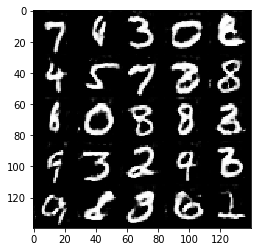

Step: 1-3250 | Generator Loss: 1.4698 | Discriminator Loss: 0.7543
Step: 1-3300 | Generator Loss: 1.4798 | Discriminator Loss: 0.6997
Step: 1-3350 | Generator Loss: 0.2844 | Discriminator Loss: 2.2120
Step: 1-3400 | Generator Loss: 0.7785 | Discriminator Loss: 1.1262
Step: 1-3450 | Generator Loss: 1.5634 | Discriminator Loss: 0.7267
Step: 1-3500 | Generator Loss: 1.0951 | Discriminator Loss: 0.8570
Step: 1-3550 | Generator Loss: 2.2551 | Discriminator Loss: 0.5103
Step: 1-3600 | Generator Loss: 0.9941 | Discriminator Loss: 1.1512


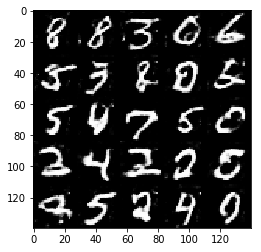

Step: 1-3650 | Generator Loss: 1.0421 | Discriminator Loss: 1.1212
Step: 1-3700 | Generator Loss: 0.1134 | Discriminator Loss: 3.1231
Step: 1-3750 | Generator Loss: 1.4202 | Discriminator Loss: 0.8085
Final output


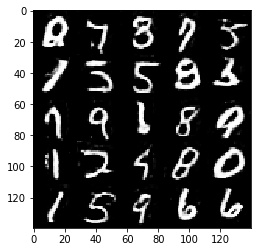

In [43]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

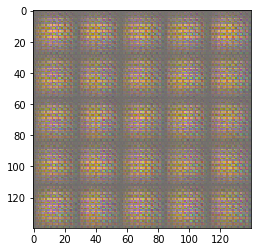

Step: 0-50 | Generator Loss: 0.4991 | Discriminator Loss: 1.9609
Step: 0-100 | Generator Loss: 0.7965 | Discriminator Loss: 1.0493
Step: 0-150 | Generator Loss: 0.8357 | Discriminator Loss: 1.0660
Step: 0-200 | Generator Loss: 2.3184 | Discriminator Loss: 1.1622
Step: 0-250 | Generator Loss: 0.9839 | Discriminator Loss: 0.8236
Step: 0-300 | Generator Loss: 0.5066 | Discriminator Loss: 1.3987
Step: 0-350 | Generator Loss: 1.6289 | Discriminator Loss: 0.8193
Step: 0-400 | Generator Loss: 0.9506 | Discriminator Loss: 1.2477


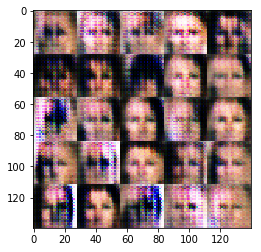

Step: 0-450 | Generator Loss: 0.5973 | Discriminator Loss: 1.3486
Step: 0-500 | Generator Loss: 0.6834 | Discriminator Loss: 1.3654
Step: 0-550 | Generator Loss: 0.7671 | Discriminator Loss: 1.1425
Step: 0-600 | Generator Loss: 0.5252 | Discriminator Loss: 1.4466
Step: 0-650 | Generator Loss: 0.7313 | Discriminator Loss: 1.2525
Step: 0-700 | Generator Loss: 2.3903 | Discriminator Loss: 1.2287
Step: 0-750 | Generator Loss: 1.0150 | Discriminator Loss: 1.2710
Step: 0-800 | Generator Loss: 0.4515 | Discriminator Loss: 1.4686


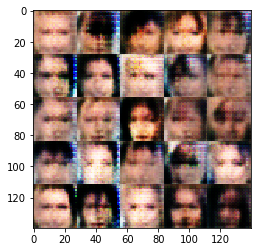

Step: 0-850 | Generator Loss: 1.8112 | Discriminator Loss: 1.4079
Step: 0-900 | Generator Loss: 0.6846 | Discriminator Loss: 1.2359
Step: 0-950 | Generator Loss: 0.7409 | Discriminator Loss: 1.2342
Step: 0-1000 | Generator Loss: 0.8391 | Discriminator Loss: 1.2615
Step: 0-1050 | Generator Loss: 0.8236 | Discriminator Loss: 0.9964
Step: 0-1100 | Generator Loss: 0.5979 | Discriminator Loss: 1.0941
Step: 0-1150 | Generator Loss: 0.8349 | Discriminator Loss: 1.0568
Step: 0-1200 | Generator Loss: 0.8320 | Discriminator Loss: 1.1635


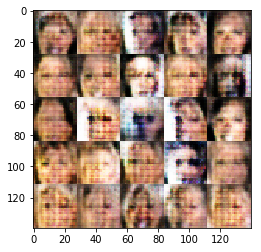

Step: 0-1250 | Generator Loss: 1.1559 | Discriminator Loss: 1.0612
Step: 0-1300 | Generator Loss: 0.4140 | Discriminator Loss: 1.5474
Step: 0-1350 | Generator Loss: 1.3265 | Discriminator Loss: 1.0722
Step: 0-1400 | Generator Loss: 0.6945 | Discriminator Loss: 1.1819
Step: 0-1450 | Generator Loss: 0.3751 | Discriminator Loss: 1.5561
Step: 0-1500 | Generator Loss: 1.2606 | Discriminator Loss: 1.3000
Step: 0-1550 | Generator Loss: 0.7540 | Discriminator Loss: 1.2427
Step: 0-1600 | Generator Loss: 0.6499 | Discriminator Loss: 1.4384


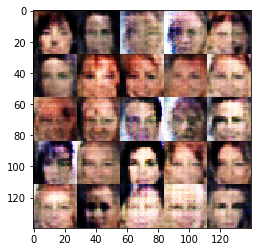

Step: 0-1650 | Generator Loss: 0.8145 | Discriminator Loss: 1.1408
Step: 0-1700 | Generator Loss: 0.4805 | Discriminator Loss: 1.5138
Step: 0-1750 | Generator Loss: 0.7901 | Discriminator Loss: 1.0729
Step: 0-1800 | Generator Loss: 1.1126 | Discriminator Loss: 1.0948
Step: 0-1850 | Generator Loss: 1.0312 | Discriminator Loss: 1.0561
Step: 0-1900 | Generator Loss: 0.5335 | Discriminator Loss: 1.4351
Step: 0-1950 | Generator Loss: 0.7070 | Discriminator Loss: 1.1431
Step: 0-2000 | Generator Loss: 0.8692 | Discriminator Loss: 1.2776


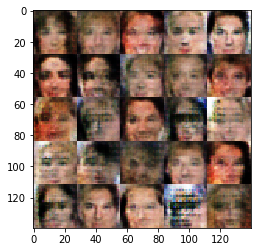

Step: 0-2050 | Generator Loss: 0.9152 | Discriminator Loss: 0.9170
Step: 0-2100 | Generator Loss: 0.6769 | Discriminator Loss: 1.1284
Step: 0-2150 | Generator Loss: 1.0612 | Discriminator Loss: 0.7688
Step: 0-2200 | Generator Loss: 0.7070 | Discriminator Loss: 1.3022
Step: 0-2250 | Generator Loss: 0.5564 | Discriminator Loss: 1.4430
Step: 0-2300 | Generator Loss: 0.6884 | Discriminator Loss: 1.1256
Step: 0-2350 | Generator Loss: 0.5358 | Discriminator Loss: 1.2647
Step: 0-2400 | Generator Loss: 0.8469 | Discriminator Loss: 1.1697


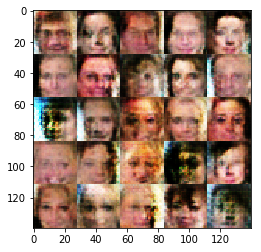

Step: 0-2450 | Generator Loss: 0.7449 | Discriminator Loss: 1.2652
Step: 0-2500 | Generator Loss: 0.3028 | Discriminator Loss: 1.7362
Step: 0-2550 | Generator Loss: 0.3228 | Discriminator Loss: 1.7367
Step: 0-2600 | Generator Loss: 0.8328 | Discriminator Loss: 2.1813
Step: 0-2650 | Generator Loss: 0.7205 | Discriminator Loss: 1.2664
Step: 0-2700 | Generator Loss: 0.5902 | Discriminator Loss: 1.3476
Step: 0-2750 | Generator Loss: 0.3426 | Discriminator Loss: 1.5814
Step: 0-2800 | Generator Loss: 0.8856 | Discriminator Loss: 0.9222


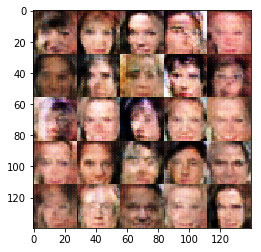

Step: 0-2850 | Generator Loss: 0.6232 | Discriminator Loss: 1.1645
Step: 0-2900 | Generator Loss: 1.3245 | Discriminator Loss: 0.6147
Step: 0-2950 | Generator Loss: 0.5140 | Discriminator Loss: 1.3741
Step: 0-3000 | Generator Loss: 0.5713 | Discriminator Loss: 1.2105
Step: 0-3050 | Generator Loss: 1.4799 | Discriminator Loss: 0.5033
Step: 0-3100 | Generator Loss: 1.0369 | Discriminator Loss: 1.1290
Step: 0-3150 | Generator Loss: 0.5675 | Discriminator Loss: 1.4407
Step: 0-3200 | Generator Loss: 0.8473 | Discriminator Loss: 1.1503


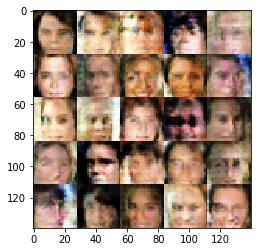

Step: 0-3250 | Generator Loss: 0.6452 | Discriminator Loss: 1.2128
Step: 0-3300 | Generator Loss: 1.5152 | Discriminator Loss: 0.7225
Step: 0-3350 | Generator Loss: 0.4591 | Discriminator Loss: 1.3731
Step: 0-3400 | Generator Loss: 0.4154 | Discriminator Loss: 1.5778
Step: 0-3450 | Generator Loss: 0.6504 | Discriminator Loss: 1.3492
Step: 0-3500 | Generator Loss: 0.6519 | Discriminator Loss: 1.1841
Step: 0-3550 | Generator Loss: 0.3364 | Discriminator Loss: 1.6360
Step: 0-3600 | Generator Loss: 0.4182 | Discriminator Loss: 1.4248


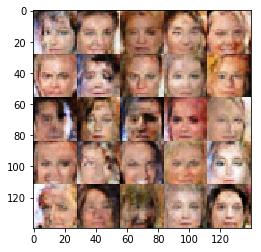

Step: 0-3650 | Generator Loss: 1.0997 | Discriminator Loss: 0.6966
Step: 0-3700 | Generator Loss: 1.5343 | Discriminator Loss: 0.5671
Step: 0-3750 | Generator Loss: 0.4223 | Discriminator Loss: 1.4696
Step: 0-3800 | Generator Loss: 1.5406 | Discriminator Loss: 0.5469
Step: 0-3850 | Generator Loss: 1.1817 | Discriminator Loss: 0.8063
Step: 0-3900 | Generator Loss: 0.5739 | Discriminator Loss: 1.2790
Step: 0-3950 | Generator Loss: 1.0360 | Discriminator Loss: 0.8891
Step: 0-4000 | Generator Loss: 1.2859 | Discriminator Loss: 0.6160


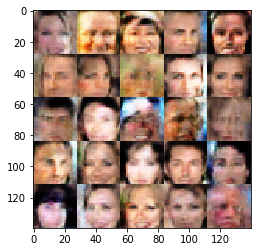

Step: 0-4050 | Generator Loss: 0.6472 | Discriminator Loss: 1.2495
Step: 0-4100 | Generator Loss: 0.5284 | Discriminator Loss: 1.4224
Step: 0-4150 | Generator Loss: 2.3077 | Discriminator Loss: 1.1774
Step: 0-4200 | Generator Loss: 1.8275 | Discriminator Loss: 0.5762
Step: 0-4250 | Generator Loss: 0.4133 | Discriminator Loss: 1.4549
Step: 0-4300 | Generator Loss: 2.5372 | Discriminator Loss: 0.3357
Step: 0-4350 | Generator Loss: 0.7888 | Discriminator Loss: 1.1446
Step: 0-4400 | Generator Loss: 0.5721 | Discriminator Loss: 1.4098


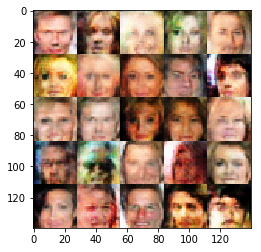

Step: 0-4450 | Generator Loss: 0.3851 | Discriminator Loss: 1.5478
Step: 0-4500 | Generator Loss: 0.4666 | Discriminator Loss: 1.4128
Step: 0-4550 | Generator Loss: 4.9103 | Discriminator Loss: 0.4810
Step: 0-4600 | Generator Loss: 0.9142 | Discriminator Loss: 1.1502
Step: 0-4650 | Generator Loss: 0.5201 | Discriminator Loss: 1.5223
Step: 0-4700 | Generator Loss: 2.4772 | Discriminator Loss: 0.5184
Step: 0-4750 | Generator Loss: 0.6436 | Discriminator Loss: 1.3125
Step: 0-4800 | Generator Loss: 0.5557 | Discriminator Loss: 1.4467


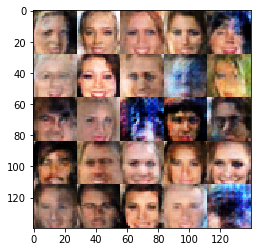

Step: 0-4850 | Generator Loss: 0.7687 | Discriminator Loss: 1.2722
Step: 0-4900 | Generator Loss: 0.4409 | Discriminator Loss: 1.5435
Step: 0-4950 | Generator Loss: 0.9768 | Discriminator Loss: 1.3895
Step: 0-5000 | Generator Loss: 0.9474 | Discriminator Loss: 1.3223
Step: 0-5050 | Generator Loss: 4.9557 | Discriminator Loss: 4.3553
Step: 0-5100 | Generator Loss: 0.5044 | Discriminator Loss: 1.5256
Step: 0-5150 | Generator Loss: 0.6906 | Discriminator Loss: 1.1894
Step: 0-5200 | Generator Loss: 0.5557 | Discriminator Loss: 1.3926


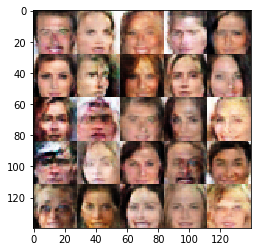

Step: 0-5250 | Generator Loss: 1.3084 | Discriminator Loss: 0.7801
Step: 0-5300 | Generator Loss: 0.7111 | Discriminator Loss: 1.1930
Step: 0-5350 | Generator Loss: 0.4361 | Discriminator Loss: 1.5555
Step: 0-5400 | Generator Loss: 0.6687 | Discriminator Loss: 1.2582
Step: 0-5450 | Generator Loss: 0.5959 | Discriminator Loss: 1.3376
Step: 0-5500 | Generator Loss: 0.6965 | Discriminator Loss: 1.2657
Step: 0-5550 | Generator Loss: 0.4616 | Discriminator Loss: 1.3522
Step: 0-5600 | Generator Loss: 0.5960 | Discriminator Loss: 1.4692


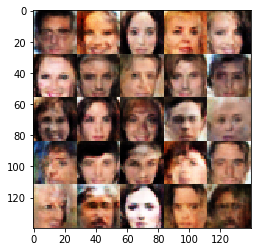

Step: 0-5650 | Generator Loss: 0.9078 | Discriminator Loss: 0.9510
Step: 0-5700 | Generator Loss: 0.8643 | Discriminator Loss: 1.0427
Step: 0-5750 | Generator Loss: 0.6472 | Discriminator Loss: 1.2902
Step: 0-5800 | Generator Loss: 0.4327 | Discriminator Loss: 1.6204
Step: 0-5850 | Generator Loss: 0.2662 | Discriminator Loss: 1.8729
Step: 0-5900 | Generator Loss: 0.4659 | Discriminator Loss: 1.5352
Step: 0-5950 | Generator Loss: 0.5519 | Discriminator Loss: 1.3572
Step: 0-6000 | Generator Loss: 0.8176 | Discriminator Loss: 0.9267


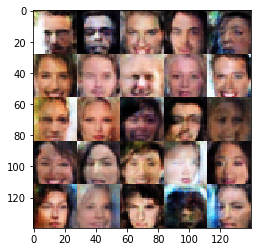

Step: 0-6050 | Generator Loss: 0.5864 | Discriminator Loss: 1.3376
Step: 0-6100 | Generator Loss: 0.4250 | Discriminator Loss: 1.4891
Step: 0-6150 | Generator Loss: 0.2570 | Discriminator Loss: 1.8837
Step: 0-6200 | Generator Loss: 0.4614 | Discriminator Loss: 1.5552
Step: 0-6250 | Generator Loss: 0.5254 | Discriminator Loss: 1.6552
Step: 0-6300 | Generator Loss: 0.5854 | Discriminator Loss: 1.3553
Final output


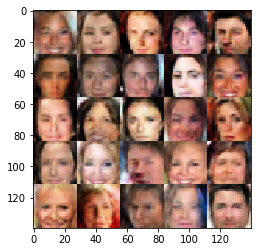

In [44]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.